# Replication - Heart

Here we provide a notebook to replicate the application to the heart data set from R-Survival


The notebook replicates the results in:
- /out/application/heart/*

The main script can be found at: 
- /scripts/application/heart.py
- /scripts/application/heart.R

In [ ]:
# google colab specific - installing probcox
!pip3 install probcox

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 614kB 13.4MB/s 
  Created wheel for probcox: filename=probcox-0.0.5-cp37-none-any.whl size=5226 sha256=84c1d2a7fd28e56bea051e515dd560c86de3a39ac86890d7276a0d89453bcce7
  Stored in directory: /root/.cache/pip/wheels/7a/ed/e5/71cb95c54c96702f1412114114806c74394f421b6cbda6af70
Successfully built probcox


In [ ]:
# Modules
# =======================================================================================================================
import os
import sys
import shutil
import subprocess
import tqdm

import numpy as np
import pandas as pd

import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist

from pyro.infer import SVI, Trace_ELBO

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import probcox as pcox

dtype = torch.FloatTensor

np.random.seed(546)
torch.manual_seed(679)

In [ ]:
# Loading Data
# =======================================================================================================================
url = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/data/application/heart.csv'
heart = pd.read_csv(url, sep=',')

surv = np.asarray(heart[['start', 'stop', 'event']])
X = np.asarray(heart.iloc[:, 4:])

surv = torch.from_numpy(surv).type(torch.FloatTensor)
X = torch.from_numpy(X).type(torch.FloatTensor)

total_obs = surv.shape[0]
batch_size = 64
total_events = torch.sum(surv[:, -1] == 1)
sampling_proportion = [total_obs, batch_size, total_events, None]

100%|██████████| 10000/10000 [01:05<00:00, 153.24it/s]


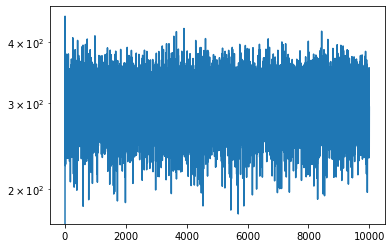

In [ ]:
# Inference
# =======================================================================================================================
run = True
eta = 1.0
while run:
    run = False
    pyro.clear_param_store()
    m = pcox.PCox(sampling_proportion=sampling_proportion)
    m.initialize(eta=eta, num_particles=5)
    loss=[0]
    for ii in tqdm.tqdm(range((10000))):
        idx = np.random.choice(range(surv.shape[0]), batch_size, replace=False)
        data=[surv[idx], X[idx]]
        if torch.sum(data[0][:, -1]) > 0:
            loss.append(m.infer(data=data))
        if loss[-1] != loss[-1]:
            eta = eta * 0.5
            run=True
            break
    g = m.return_guide()
    out = g.quantiles([0.025, 0.5, 0.975])
plt.semilogy(loss)



In [ ]:
# Prepare summary tables
# =======================================================================================================================
a = np.round(out['theta'][1].detach().numpy()[:, 0], 2)
b = np.round(torch.diag(pyro.get_param_store()['AutoMultivariateNormal.scale_tril']).detach().numpy(), 2)
c =np.sign(out['theta'][0].detach().numpy()) == np.sign(out['theta'][2].detach().numpy())
for ii in range(X.shape[1]):
    if c[ii]:
        sig = '*'
    else:
        sig = ''
    print(str(a[ii]) + sig + ', (' + str(b[ii]) + ')')

ci = pcox.metrics(surv=surv.numpy(), linpred=torch.mm(X, out['theta'][1].detach()).numpy(), processes=4).concordance()[None]
print(ci)

0.28*, (0.13)
-0.29*, (0.14)
-0.63, (0.35)
0.0, (0.29)
[0.63506261]


In [ ]:
# load R 
%load_ext rpy2.ipython

In [ ]:
# install packages
%%R 
install.packages('survival')

library(survival)

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/survival_3.2-11.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 6274168 bytes (6.0 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[w

In [ ]:
%%R 
rm(list=ls())
library(survival)
data("heart")
heart = heart[complete.cases(heart),]

heart = data.frame(c(heart['start'], heart['stop'], heart['event'], heart['age'], heart['year'], heart['surgery'],  heart['transplant']))

standardize <- function(x){
(x - mean(x))/sqrt(var(x))
}
names(heart)
heart[ , c(4, 5)] = apply(heart[ , c(4, 5)], 2, standardize)

m = coxph(Surv(start, stop, event) ~., data=heart)
summary(m)



Call:
coxph(formula = Surv(start, stop, event) ~ ., data = heart)

  n= 172, number of events= 75 

                coef exp(coef) se(coef)      z Pr(>|z|)  
age          0.25591   1.29164  0.12919  1.981   0.0476 *
year        -0.26707   0.76562  0.12860 -2.077   0.0378 *
surgery     -0.63721   0.52877  0.36723 -1.735   0.0827 .
transplant1 -0.01025   0.98980  0.31375 -0.033   0.9739  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            exp(coef) exp(-coef) lower .95 upper .95
age            1.2916     0.7742    1.0027    1.6638
year           0.7656     1.3061    0.5950    0.9851
surgery        0.5288     1.8912    0.2574    1.0860
transplant1    0.9898     1.0103    0.5352    1.8307

Concordance= 0.636  (se = 0.033 )
Likelihood ratio test= 15.11  on 4 df,   p=0.004
Wald test            = 14.49  on 4 df,   p=0.006
Score (logrank) test = 15.03  on 4 df,   p=0.005

